<a href="https://colab.research.google.com/github/fell100/Machine-Learning/blob/master/Felipe_Miranda_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aluno: Felipe Miranda Cardoso <br>
Professor: Carlos Galvão <br>
Matrícula: 201802677

Neste exercicio vamos começar a trabalhar com dados mais interessantes, o Fashion MNIST, que tem imagens de acessórios de vestuário. Vamos ainda verificar outros aspectos ao trabalhar com redes neurais usando PyTorch:

*   dataloader
*   transformação 
*   batches
*   Overfitting



## Carregando dados e usando transformações

In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
#Carregar os dados
trainset = datasets.FashionMNIST('./F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./F_MNIST_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./F_MNIST_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./F_MNIST_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./F_MNIST_data/FashionMNIST/raw



A célula acima fez três operações:


1. Definiu uma transformação a ser aplicada a cada uma das imagens.

`transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])`

Essa linha determina que os dados serão armazenados em um tensor e normalizados com média 0.5 e desvio padrão 0.5.
Outras transformações são possíveis, como rotação, por exemplo.

2. Faz o download da base de dados Fashion MNIST

`trainset = datasets.FashionMNIST('./F_MNIST_data/', download=True, train=True, transform=transform)`

Essa linha faz o download a partir de training.pt e aplica as transformações definidas anteriormente

3. Define um dataloader com a linha

`
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)`

que fornece um conjunto de 64 imagens misturadas cada vez que você solicitar.

A seguir, vamos obter os dados para teste, usando a mesma transformação.



In [3]:
testset = datasets.FashionMNIST('./F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Vamos observar alguns dados. Cada vez que você executar a célula, um novo conjunto de dados é carregado.

Quantidade de imagens: 64
Largura: 28, Altura: 28
Valores máximos e mínimos das imagens: 1.0, -1.0
tensor([8, 4, 0, 0, 3, 1, 3, 5, 8, 8, 6, 6, 3, 9, 2, 9, 7, 6, 7, 9, 4, 2, 9, 2,
        7, 6, 6, 6, 3, 4, 0, 2, 3, 6, 5, 0, 0, 6, 7, 2, 5, 3, 8, 3, 5, 5, 4, 6,
        2, 6, 3, 8, 7, 5, 6, 2, 6, 0, 5, 1, 5, 9, 0, 6])


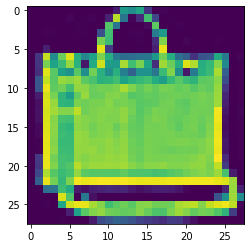

In [4]:
images, labels = next(iter(trainloader))
print(f"Quantidade de imagens: {images.shape[0]}")
print(f"Largura: {images.shape[2]}, Altura: {images.shape[3]}")
print(f"Valores máximos e mínimos das imagens: {images.max()}, {images.min()}")
plt.imshow(images[0][0].numpy())
print(labels)

Verificamos que as imagens são de dimensões 28x28 e com valores entre -1 e 1 (normalização feita na transformação). 

Além disso, vemos 10 classes diferentes, com o vetor apresentando valores entre 0 e 9. 

**Obs**: *Como a filosofia do PyTorch é facilitar a vida do usuário, podemos usar os rótulos dessa forma. Em outras soluções, é necessário fazer o hot-encoding. Isso transforma um vetor de N rótulos de C classes para uma matriz $N$x$C$ em que cada linha tem apenas um valor 1.*

Agora, vamos criar a nossa rede!

In [5]:
nInputs = images.shape[2]*images.shape[3]#784
nHidden1 = 500
nHidden2 = 200
nHidden3 = 50
nOutput = 10
learningRate = 0.003
model = torch.nn.Sequential(
    torch.nn.Linear(nInputs, nHidden1),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),

    torch.nn.Linear(nHidden1, nHidden2),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),

    torch.nn.Linear(nHidden2, nHidden3),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    
    torch.nn.Linear(nHidden3, nOutput),
    torch.nn.LogSoftmax(dim=1),
    )  

criterion = torch.nn.NLLLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate) 

Vamos verificar a saída da rede para o lote (batch) de imagens. As classes estimadas podem ser obtidas com argmax() e a acurácia **provavelmente** será próxima de 10%.

In [6]:
inputs = images.reshape(images.shape[0],-1)
outputs = model(inputs)
outputsClass = torch.argmax(outputs, dim=1)
accuracy = 100*(outputsClass==labels).sum()/len(labels)
print(accuracy)

tensor(4.6875)




O próximo passo e treinar a rede. Fizemos algumas modificações no código a seguir. 

*   A cada lote, fazemos o ajuste do modelo e o erro é acumulado dentro de cada época.
*   Verificamos o erro para dados não usados no treinamento para validar o aprendizado.
*   Os dados são achatados(```images.reshape(images.shape[0],-1)```) uma vez que a rede tem 784 entradas e espera uma matriz $N$x$784$ e não $N$x$28$x$28$

In [7]:
def train_model(nEpochs = 20):
  errors_train=[]
  errors_test=[]
  accuracy_test=[]
  for epoch in range(nEpochs):
    #carrega dados de lote
    train_loss=0
    for images, labels in trainloader:
    #images, labels = next(iter(trainloader))
      if torch.cuda.is_available():
        images.to('cuda')
        labels.to('cuda')
      #ajusta as dimensões
      model.train()
      inputs = images.reshape(images.shape[0],-1)
      #zera o gradiente
      optimizer.zero_grad()
      #propaga os dados na rede
      outputs = model(inputs)
      #calcula o erro
      
      #torch.nn.Dropout()
      loss = criterion(outputs, labels)
      train_loss+=loss.item()
      #calcula gradientes com backward

      loss.backward()
      #faz um passo de otimização
      
      optimizer.step()
      #calcula a acurácia
      model.eval()
      outputsClass = torch.argmax(outputs, dim=1)
      accuracy = 100*(outputsClass==labels).sum()/len(labels)
      #usa os dados de fora do grupo de teste para fazer a validação

    with torch.no_grad():
      test_correct = 0
      test_loss=0
      for images, labels in testloader:
        if torch.cuda.is_available():
          images.to('cuda')
          labels.to('cuda')        
        inputs = images.reshape(images.shape[0],-1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss+=loss.item()
        outputsClass = torch.argmax(outputs, dim=1)
        test_correct += (outputsClass==labels).sum()
    train_loss = train_loss/len(trainloader.dataset)
    test_loss = test_loss/len(testloader.dataset)
    errors_train.append(train_loss)
    errors_test.append(test_loss)
    print(f"Epochs: {epoch}, error train: {errors_train[-1]}, error test: {errors_test[-1]}")
  return errors_train, errors_test

Após executar a pŕoxima célula, aproveite para fazer uma pausa. 

Tome um café, faça um exercício ou dê um abraço em quem mora com você :)

Com trinta épocas, você terá alguns minutos para isso.

In [8]:
errors_train, errors_test = train_model(30)

Epochs: 0, error train: 0.8568046522776286, error test: 0.5684108416557312
Epochs: 1, error train: 0.7284784877141317, error test: 0.5919969269275666
Epochs: 2, error train: 0.6994401970863342, error test: 0.5347790493011475
Epochs: 3, error train: 0.671664747428894, error test: 0.5041235728263855
Epochs: 4, error train: 0.6503279267628987, error test: 0.4923662349700928
Epochs: 5, error train: 0.6499323974450429, error test: 0.4688708051681519
Epochs: 6, error train: 0.6312813276290894, error test: 0.45725058941841124
Epochs: 7, error train: 0.621526645676295, error test: 0.5015611144065857
Epochs: 8, error train: 0.6359030595779419, error test: 0.465824342918396
Epochs: 9, error train: 0.6128222301801046, error test: 0.44774319925308226
Epochs: 10, error train: 0.6181075229326884, error test: 0.47172426404953005
Epochs: 11, error train: 0.6179687894980113, error test: 0.4749583392858505
Epochs: 12, error train: 0.6009168228626252, error test: 0.46206502304077146
Epochs: 13, error tra

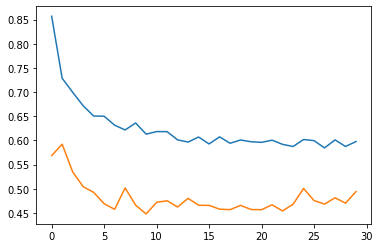

In [9]:
plt.plot(errors_train)
plt.plot(errors_test)

Se você não alterou o código, Provavelmente, a partir da 10a. época, o erro com os dados de treinamento continuam caindo, enquanto o erro dos dados de teste apresentam uma tendência de alta. 

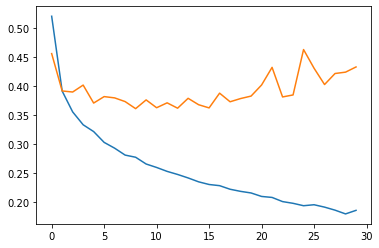

Esse fenômeno é conhecido como *overfitting*. Isso significa que a rede está ficando muito boa com os dados usados para o ajuste dos pesos, mas está perdendo a sua capacidade de generalização.

Algumas medidas podem ser tomadas para evitar o *overfitting* e um deles é o dropout, que vamos usar a seguir.

## **Tarefa**

Uma das maneiras de combater o overfitting é dropout.
Durante o treinamento, entradas e neurônios são dasabilitados com probabilidade $p$. Isso quer dizer que nem todas as unidades terão seus pesos atualizados.

O que você deve fazer aqui é:

- Usar o `torch.nn.Dropout()` na definição do modelo (verifique a [documentação](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout))
- Verificar quando usar `model.eval()` e `model.train()`

Se tudo der certo, você vai verificar que o overfitting foi eliminado ou atenuado, ao menos.

Você deve chegar em algo parecido com isso:

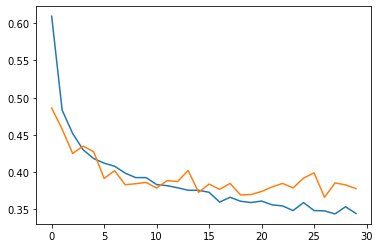